In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Essential functions

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torchvision import transforms as T
from torchvision import utils
import os
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm
import numpy as np

#### Dataloaders

In [2]:
# Parse XML files
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = []
    for obj in root.iter('object'):
        obj_dict = {
            'name': obj.find('name').text,
            'bbox': [
                int(obj.find('bndbox/xmin').text),
                int(obj.find('bndbox/ymin').text),
                int(obj.find('bndbox/xmax').text),
                int(obj.find('bndbox/ymax').text)
            ]
        }
        objects.append(obj_dict)
    return objects

# Visual bounding boxes
def visualize_image(image_path, objects):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR by default
    for obj in objects:
        bbox = obj['bbox']
        cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(image, obj['name'], (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    plt.imshow(image)
    plt.show()



In [3]:
your_label_map = {
    "Grasper": 1,
    "Bipolar": 2,
    "Hook": 3,
    "Scissors": 4,
    "Clipper": 5,
    "Irrigator": 6,
    "SpecimenBag": 7
}


def resize_bbox(bbox, in_size, out_size):
    """
    Adjust bounding box size.
    :param bbox: Original bounding box coordinates in the format [xmin, ymin, xmax, ymax]
    :param in_size: original image size (width, height)
    :param out_size: new image size (width, height)
    :return: adjusted bounding box coordinates
    """
    xmin, ymin, xmax, ymax = bbox
    scale_x = out_size[0] / in_size[0]
    scale_y = out_size[1] / in_size[1]
    xmin = int(xmin * scale_x)
    ymin = int(ymin * scale_y)
    xmax = int(xmax * scale_x)
    ymax = int(ymax * scale_y)
    return [xmin, ymin, xmax, ymax]


class CustomDataset(Dataset):
    def __init__(self, imgs_dir, anns_dir, transforms=None):
        self.imgs_dir = imgs_dir
        self.anns_dir = anns_dir
        self.transforms = transforms

        # Get the names of all image and annotation files, with extensions removed
        anns = set(os.path.splitext(file)[0] for file in os.listdir(anns_dir))
        imgs = anns

        # Keep image file names with matching annotations
        self.imgs = [file + '.jpg' for file in imgs]  # Assuming the image file is in .jpg format
        self.annotations = [file + '.xml' for file in anns]  # Assume that the annotation file is in .xml format

        # Make sure the image and annotation file lists are of equal length
        assert len(self.imgs) == len(self.annotations), "Images and annotations lists are not the same length"

    def __getitem__(self, idx):
        # print("getting")
        img_path = os.path.join(self.imgs_dir, self.imgs[idx])
        ann_path = os.path.join(self.anns_dir, self.annotations[idx])

        # read images
        image = Image.open(img_path).convert("RGB")
        original_size = image.size
        new_size = (600, 600)

        # Parse XML files using parse_xml function
        objects = parse_xml(ann_path)


        boxes = []
        labels = []
        num_objs = len(objects)
        for obj in objects:
            label_name = obj['name']
            label = your_label_map[label_name]  # Convert category name to integer
            labels.append(label)

            # Add bounding box coordinates
            bbox = obj['bbox']
            resized_bbox = resize_bbox(bbox, original_size, new_size)
            boxes.append(resized_bbox)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["image_id"] = idx
        # target["area"] = area
        # target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)  # Apply conversion to image
            # If necessary, you can also convert the target accordingly
            # For example, if random flipping is used, the bounding box of the target needs to be adjusted accordingly

        return image, target

    def __len__(self):
        return len(self.imgs)


In [4]:
from torchvision.transforms import functional as F


# imgs_dir = "/content/m2cai16-tool-locations/JPEGImages"
# anns_dir = "/content/m2cai16-tool-locations/Annotations"

imgs_dir = "drive/MyDrive/m2cai16-tool-locations/dummy root/dummy class"
anns_dir = "drive/MyDrive/m2cai16-tool-locations/Annotations"

def get_transform(train):
    transforms = []
    # Convert PIL image to PyTorch Tensor
    transforms.append(T.ToTensor())
    # if train:
    #     # Data augmentation during training phase, such as random horizontal flipping
    #     transforms.append(T.RandomHorizontalFlip(0.5))
    #     # More data enhancement operations can be added, such as:
    #     # transforms.append(T.RandomVerticalFlip(0.5))
    #     # transforms.append(T.ColorJitter(...))
    transforms.append(T.Resize((600, 600), antialias=None))  # 以 600x600 为例
    return T.Compose(transforms)


def collate_fn(batch):
    # Stack or pack images and targets separately, because images have different numbers of boxes
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    images = default_collate(images)  # Use default stacking method for images
    # Targets do not need to be stacked as they may be of different lengths
    return images, targets


# Create a dataset instance
dataset = CustomDataset(imgs_dir, anns_dir, transforms=get_transform(True))
# data_loader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4, collate_fn=collate_fn)

generator2 = torch.Generator().manual_seed(42)
split_data = torch.utils.data.random_split(dataset, [0.7, 0.2, 0.1], generator=generator2)
train_dataset = split_data[0]
val_dataset = split_data[1]
test_dataset = split_data[2]

# len(train_dataset), len(val_dataset), len(test_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_datalaoder = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)


#### IoU function

In [5]:
def calculate_iou_for_labels(true_labels, pred_labels):
    # Initialize a list to store IoU values
    iou_values = []

    # Iterate over the pairs of true and predicted boxes
    for true_box, pred_box in zip(true_labels['boxes'], pred_labels['boxes']):
        # Extract box coordinates and convert to standard list format
        true_box = [b.item() for b in true_box]
        pred_box = [b.item() for b in pred_box]

        # Calculate the coordinates of the intersection rectangle
        xA = max(true_box[0], pred_box[0])
        yA = max(true_box[1], pred_box[1])
        xB = min(true_box[2], pred_box[2])
        yB = min(true_box[3], pred_box[3])

        # Compute the area of intersection rectangle
        interArea = max(0, xB - xA) * max(0, yB - yA)

        # Compute the area of both bounding boxes
        boxAArea = (true_box[2] - true_box[0]) * (true_box[3] - true_box[1])
        boxBArea = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])

        # Compute the intersection over union
        iou = interArea / float(boxAArea + boxBArea - interArea)

        # Append the IoU value to the list
        iou_values.append(iou)

    return iou_values

def calculate_iou_for_matching_classes_ordered(true_labels, pred_labels):
    iou_values = []

    # Iterate over each true box and its class
    for true_box, true_class in zip(true_labels['boxes'], true_labels['labels']):
        # Convert true box to standard list format
        true_box = [b.item() for b in true_box]

        best_iou = 0
        best_iou_class = None

        # Iterate over each predicted box and its class
        for pred_box, pred_class in zip(pred_labels['boxes'], pred_labels['labels']):
            # Check if the classes match
            if true_class == pred_class:
                # Convert predicted box to standard list format
                pred_box = [b.item() for b in pred_box]

                # Calculate IoU
                iou = calculate_single_iou(true_box, pred_box)

                # Update best IoU and class if current IoU is higher
                if iou > best_iou:
                    best_iou = iou
                    best_iou_class = pred_class

        if best_iou_class is not None:
            # Append the best IoU value and class to the list
            iou_values.append((best_iou, best_iou_class))

    return iou_values

def calculate_single_iou(boxA, boxB):
    # Calculate the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both bounding boxes
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the intersection over union
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

def evaluate_model_on_validation_set(model, dataloader, device):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # Process only tensors in targets (like 'boxes' and 'labels'), ignore other data types
            # targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]

            # Get model predictions
            preds = model(images)

            # Convert predictions and targets to CPU and to numpy arrays for IoU calculation
            for target, pred in zip(targets, preds):
                true_labels = {'boxes': target['boxes'].cpu(), 'labels': target['labels'].cpu()}
                pred_labels = {'boxes': pred['boxes'].cpu(), 'labels': pred['labels'].cpu()}
                iou_values = calculate_iou_for_matching_classes_ordered(true_labels, pred_labels)
                iou_scores.extend([iou for iou, _ in iou_values])

    # Calculate average IoU
    average_iou = np.mean(iou_scores) if iou_scores else 0
    return average_iou

In [6]:
import matplotlib.patches as patches
def display_image_with_boxes_true(image, true_labels):
    fig, ax = plt.subplots(1)
    image = image.cpu()
    t = ToPILImage()
    image = t(image)

    # Image with true labels
    ax.imshow(image)
    n_obj_true = len(true_labels['boxes'])
    boxes = true_labels['boxes']
    labels = true_labels['labels']

    for i in range(n_obj_true):
      xmin, ymin, xmax, ymax = boxes[i][0].item(), boxes[i][1].item(), boxes[i][2].item(), boxes[i][3].item()
      rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                               linewidth = 1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.text(xmin, ymin-5, labels[i], color='r')
    plt.show()


def display_image_with_boxes_pred(image, pred_labels):

    fig, ax = plt.subplots(1)
    image = image.cpu()
    t = ToPILImage()
    image = t(image)

    # Image with predicted labels
    ax.imshow(image)
    n_obj_true = len(pred_labels['boxes'])
    boxes = pred_labels['boxes']
    labels = pred_labels['labels']
    scores = pred_labels['scores']

    for i in range(n_obj_true):
      if(scores[i]>0.8):
        xmin, ymin, xmax, ymax = boxes[i][0].item(), boxes[i][1].item(), boxes[i][2].item(), boxes[i][3].item()
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                                linewidth = 1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin-5, labels[i], color='r')
        print(labels[i]) #del
    plt.show()

In [7]:
from torchvision.transforms import ToPILImage
t = ToPILImage()
# train_features, train_labels = next(iter(train_dataloader))
# print(train_features.shape)
# t(train_features[0].squeeze(dim=0))

In [8]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load pre-trained model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of input features of the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head of a pretrained model to adapt to the number of classes in your dataset
# Assume your dataset has num_classes classes (including background)
num_classes = 8
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# choose optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005) #sgd original

# training epoch
num_epochs = 20

train_losses = []
val_IoU = []

for epoch in range(num_epochs):
    model.train()
    for images, targets in tqdm(train_dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]


        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    train_loss = losses.item()
    train_losses.append(train_loss)

    model.eval()
    average_iou = evaluate_model_on_validation_set(model, val_datalaoder, device)
    val_IoU.append(average_iou)

    print(f"\nEpoch {epoch} Train Loss: {train_loss:.4f}")
    print(f"Epoch {epoch} Val IoU: {average_iou:.4f}\n")

 99%|█████████▉| 195/197 [06:34<00:04,  2.19s/it]

### Plots

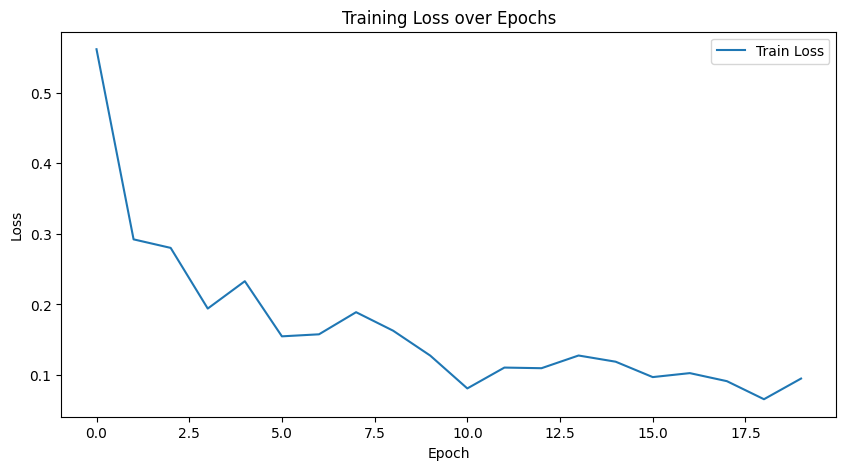

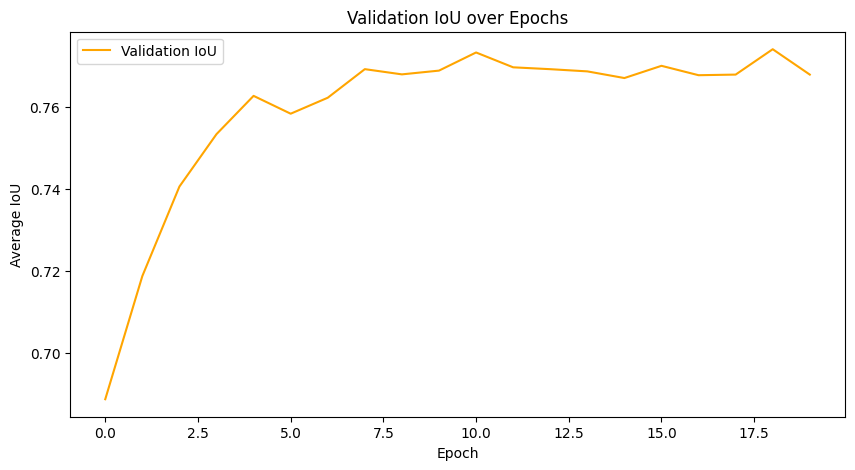

In [ ]:
import matplotlib.pyplot as plt

# Assuming train_losses and val_IoU are filled with values from the training loop

# Plot for Training Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.savefig('/content/drive/MyDrive/m2cai16-tool-locations/train_loss_plot.png')
plt.show()

# Plot for Validation IoU
plt.figure(figsize=(10, 5))
plt.plot(val_IoU, label='Validation IoU', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Average IoU')
plt.title('Validation IoU over Epochs')
plt.legend()
plt.savefig('/content/drive/MyDrive/m2cai16-tool-locations/val_iou_plot.png')
plt.show()


### Saving or loading models

In [ ]:
model_path = "drive/MyDrive/m2cai16-tool-locations/fastRCNN_train_ep20.pth"
torch.save(model.state_dict(), model_path)

In [ ]:
# model_path = "drive/MyDrive/m2cai16-tool-locations/fastRCNN.pth"
# model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
import numpy as np

def draw_boxes(image, boxes, labels):
    fig, ax = plt.subplots(1)
    # image = image.cpu()
    t = ToPILImage()
    image = t(image)

    # Image with true labels
    ax.imshow(image)
    n_obj_true = len(boxes)

    for i in range(n_obj_true):
      xmin, ymin, xmax, ymax = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
      rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                               linewidth = 1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)
      plt.text(xmin, ymin-5, labels[i], color='r')
    plt.show()

def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    # print(outputs)
    pred_classes = outputs[0]['labels'].cpu().numpy()
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()

    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    return boxes, classes, labels, indices

def predict_top(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()

    best_boxes, best_classes, best_scores = {}, {}, {}
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            cls = pred_classes[index]
            if cls not in best_scores or pred_scores[index] > best_scores[cls]:
                best_boxes[cls] = pred_bboxes[index].astype(np.int32)
                best_classes[cls] = cls
                best_scores[cls] = pred_scores[index]

    # Convert the results to lists
    boxes = list(best_boxes.values())
    classes = list(best_classes.values())
    scores = list(best_scores.values())

    return boxes, classes, scores, None

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# boxes, classes, labels, indices = predict(train_features[0].unsqueeze(dim=0).cuda(), model, device, 0.9)
# # boxes, classes, labels, indices
# # image = draw_boxes(boxes, labels, classes, train_features[0].numpy())
# # boxes[0][1]
# # Show the image:
# # Image.fromarray(image)
# draw_boxes(train_features[5], boxes, labels)


In [ ]:
# pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=fcac8123de79c8fc3e5dbeb6996841c9f6e5def455ff70270bb62b1808e3faa9
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [ ]:
activations = None

def hook(module, input, output):
    global activations
    activations = output.data

# Replace 'your_target_layer' with the actual name or index of the last convolutional layer in your Fast R-CNN model
target_layer = model.backbone.body.layer4[2].relu
hook_handle = target_layer.register_forward_hook(hook)



from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

def fasterrcnn_reshape_transform(x):
    target_size = x['pool'].size()[-2 : ]
    activations = []
    for key, value in x.items():
        activations.append(torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations


class FasterRCNNBoxScoreTarget:
    """ For every original detected bounding box specified in "bounding boxes",
    	assign a score on how the current bounding boxes match it,
    		1. In IOU
    		2. In the classification score.
    	If there is not a large enough overlap, or the category changed,
    	assign a score of 0.

    	The total score is the sum of all the box scores.
    """

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        if len(model_outputs["boxes"]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, model_outputs["boxes"])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs["labels"][index] == label:
                score = ious[0, index] + model_outputs["scores"][index]
                output = output + score
        return output

# from pytorch_grad_cam.utils.image import show_cam_on_image
# target_layers = [model.backbone]
# targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
# cam = EigenCAM(model,
#                target_layers,
#                use_cuda=torch.cuda.is_available(),
#                reshape_transform=fasterrcnn_reshape_transform)



In [ ]:
# for i in range(10):
#   print("image# ", i)
#   boxes, classes, labels, indices = predict(train_features[i].unsqueeze(dim=0).cuda(), model, device, 0.9)
#   image_float_np = train_features[i].numpy() / 255
#   grayscale_cam = cam(train_features[i].unsqueeze(dim=0), targets=targets)
#   grayscale_cam = grayscale_cam[0, :]


#   image_float_np = np.transpose(image_float_np, (1, 2, 0))
#   cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb = True)

#   # draw_boxes(cam_image, boxes, labels)
#   display_image_with_boxes_true(train_features[i], train_labels[i])
#   display_image_with_boxes_pred(train_features[i], pred[i])
#   print(calculate_iou_for_matching_classes_ordered(train_labels[i], pred[i]))
#   # for true_box, pred_box in zip(train_labels[i]['boxes'], pred[i]['boxes']):
#   #   iou = bb_intersection_over_union(true_box, pred_box)
#   #   print(f"Intersection Over Union (IoU) between true box and pred box: {iou}")


Output hidden; open in https://colab.research.google.com to view.

# Integrated gradients

In [ ]:
from torchvision.transforms import ToPILImage
test_features, test_labels = next(iter(test_dataloader))

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def process_integrated_gradients(integrated_grad):
    integrated_grad = np.abs(integrated_grad.cpu())
    integrated_grad -= integrated_grad.min()
    integrated_grad /= integrated_grad.max()
    return integrated_grad


def visualize_integrated_gradients(processed_grad):
    pil_img = ToPILImage()(processed_grad[0])
    plt.imshow(pil_img)
    plt.axis('off')
    plt.show()


def integrated_gradients(input_tensor, baseline_tensor, model, pred, steps=50):
    input_tensor.requires_grad_(True)

    interpolated_images = [baseline_tensor + (float(i) / steps) * (input_tensor - baseline_tensor) for i in range(0, steps + 1)]

    integrated_grads = 0

    model.train()

    for img in interpolated_images:

        img.requires_grad_(True)

        outputs = model(img, pred)

        total_loss = sum(loss for loss in outputs.values())

        img.retain_grad()
        model.zero_grad()
        total_loss.backward(retain_graph=True)

        integrated_grads += img.grad.data

    integrated_grads /= steps

    return integrated_grads



input_tensor = test_features[0].unsqueeze(0).to(device)
baseline = torch.zeros_like(input_tensor).to(device)


model.eval()
pred = model(input_tensor)

integrated_grad = integrated_gradients(input_tensor, baseline, model, pred)

if integrated_grad is not None:
    processed_grad = process_integrated_gradients(integrated_grad)
    
    visualize_integrated_gradients(processed_grad)
else:
    print("No valid gradient")

In [ ]:

draw_boxes(test_features[0], test_labels[0]["boxes"], test_labels[0]["labels"])

## function with IoU inbuilt

In [ ]:
import os
import utils
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")
# !pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 7
# # use our dataset and defined transformations
# dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
# dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# # split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])




# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
# model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - P

Epoch: [0]  [   0/1406]  eta: 1:11:28  lr: 0.000010  loss: 0.1458 (0.1458)  loss_classifier: 0.0345 (0.0345)  loss_box_reg: 0.1085 (0.1085)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 3.0502  data: 1.5664  max mem: 7950
Epoch: [0]  [  10/1406]  eta: 0:14:37  lr: 0.000060  loss: 0.0739 (0.1074)  loss_classifier: 0.0248 (0.0283)  loss_box_reg: 0.0499 (0.0764)  loss_objectness: 0.0001 (0.0009)  loss_rpn_box_reg: 0.0013 (0.0017)  time: 0.6286  data: 0.1499  max mem: 7950
Epoch: [0]  [  20/1406]  eta: 0:11:42  lr: 0.000110  loss: 0.0765 (0.1016)  loss_classifier: 0.0248 (0.0276)  loss_box_reg: 0.0559 (0.0718)  loss_objectness: 0.0001 (0.0007)  loss_rpn_box_reg: 0.0009 (0.0015)  time: 0.3794  data: 0.0077  max mem: 7950
Epoch: [0]  [  30/1406]  eta: 0:10:42  lr: 0.000160  loss: 0.0793 (0.0951)  loss_classifier: 0.0251 (0.0274)  loss_box_reg: 0.0561 (0.0655)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0009 (0.0014)  time: 0.3778  data: 0.0081  max me

TypeError: ignored

In [ ]:
data_loader_test = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

In [ ]:
import os
# import utils
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")
# !pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI
from engine import train_one_epoch, evaluate

evaluate(model, test_dataloader, device=device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


creating index...
index created!
Test:  [  0/281]  eta: 0:01:04  model_time: 0.0988 (0.0988)  evaluator_time: 0.0051 (0.0051)  time: 0.2294  data: 0.1234  max mem: 7346
Test:  [100/281]  eta: 0:00:06  model_time: 0.0295 (0.0309)  evaluator_time: 0.0018 (0.0019)  time: 0.0359  data: 0.0030  max mem: 7346
Test:  [200/281]  eta: 0:00:03  model_time: 0.0297 (0.0303)  evaluator_time: 0.0017 (0.0019)  time: 0.0358  data: 0.0029  max mem: 7346
Test:  [280/281]  eta: 0:00:00  model_time: 0.0297 (0.0302)  evaluator_time: 0.0018 (0.0018)  time: 0.0365  data: 0.0030  max mem: 7346
Test: Total time: 0:00:10 (0.0371 s / it)
Averaged stats: model_time: 0.0297 (0.0302)  evaluator_time: 0.0018 (0.0018)
Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.548
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.953
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.

In [ ]:
import numpy as np
from IPython.display import Audio, display

# Generate a sound
fs = 44100  # Sampling rate, or number of samples per second
duration = 1  # Duration in seconds
frequency = 440  # Frequency of the sound in Hz (A4 note)

t = np.linspace(0, duration, int(fs*duration), endpoint=False) # Time vector
sound_wave = 0.5*np.sin(2*np.pi*frequency*t)  # Generate a sine wave

# Play the sound
Audio(sound_wave, rate=fs)